Repositório com o código desenvolvido para realizar o trabalho (https://github.com/VictorHenrique317/ml-projeto-final) 

In [210]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from IPython.core.display import Image
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
# %pip install xgboost
# %pip install seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import plot_importance
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Definindo os diferentes conjuntos de features.
- X_questions são as perguntas feitas para o paciente durante a consulta.
- X_drugs são os remédios que o paciente toma.
- X é a junção de X_Questions e X_drugs.
- X_random é um conjunto de features aleatórias.

In [211]:
data = pd.read_csv('data.csv')

X_questions = data.iloc[:, 2:182] # As duas primeiras colunas são irrelevantes (id e data de nascimento)
X_questions = X_questions.drop('date_visit', axis=1) # Data de visita não é relevante
X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

X_drugs = data.iloc[:, 185:]
X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1) # Essas colunas são constantes

X_random = np.random.rand(X_questions.shape[0], 1) # Para comparar a perfomance do modelo

X = np.concatenate((X_questions, X_drugs), axis=1) # A junção das duas tabelas
X = pd.DataFrame(X)

Extraindo as 3 diferentes variáveis que indicam se o paciente teve melhora ou não

In [212]:
Y = data.iloc[:, 182:185]

y_vas30 = Y.iloc[:, 0:1].values.ravel()
y_vas50 = Y.iloc[:, 1:2].values.ravel()
y_gic = Y.iloc[:, 2:3].values.ravel()

Nesse ponto temos 3 targets diferentes, temos que decidir qual faz mais sentido usar. Pensei que não faria sentido usar uma delas e ignorar o resto, então decidi criar uma nova variável que leva em consideração as 3 diferentes avaliações de melhora (2 do paciente e uma do médico).

Primeiro criei y_perceived, que é a melhora percebida pelo paciente. Ela é definida como a disjunção entre y_vas30 e y_vas50 pois quero captar qualquer tipo de melhora percebida pelo paciente, seja ela pequena ou grande.

In [213]:
y_perceived = np.logical_or(y_vas30, y_vas50)
y_perceived = y_perceived.astype(int)

E finalmente o target (y) é definido como a interseção entre melhora percebida e GIC, pois o paciente deve perceber alguma melhora e o médico deve concordar, esse é o cenário mais conservador possível.

In [214]:
y = np.logical_and(y_perceived, y_gic)
y = y.astype(int)
y = pd.DataFrame(y)

Porém, ao fazer isso a distribuição dos dados fica desbalanceada, apenas 15% dos exemplos são de pacientes que melhoraram segundo nossa nova variável y. 

Faz sentido a porcentagem de casos positivos ser baixa em y, pois como dito em nossa reunião a maior parte dos pacientes que sofrem com dor crônica não apresentam melhora.

In [215]:
print(f"A porcentagem de casos positivos em y_gic é {(np.sum(y_gic)/y_gic.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas30 é {(np.sum(y_vas30)/y_vas30.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y_vas50 é {(np.sum(y_vas50)/y_vas50.shape[0])*100:.2f}%")
print()
print(f"A porcentagem de casos positivos em y_perceived é {(np.sum(y_perceived)/y_perceived.shape[0])*100:.2f}%")
print(f"A porcentagem de casos positivos em y é {(np.sum(y.values)/y.shape[0])*100:.2f}%")

A porcentagem de casos positivos em y_gic é 28.96%
A porcentagem de casos positivos em y_vas30 é 43.84%
A porcentagem de casos positivos em y_vas50 é 35.84%

A porcentagem de casos positivos em y_perceived é 43.84%
A porcentagem de casos positivos em y é 15.04%


Então para tornar o modelo igualmente habilidoso tanto na predição de casos negativos, quanto na predição de casos positivos é necessário remover alguns casos negativos para que a distribuição dos dados seja mais equilibrada.

Essa decisão tem um efeito adverso óbvio, o modelo terá uma menor qualidade devido a quantidade reduzida de dados. Porém,acredito que por se tratar de um modelo de grande responsábilidade (por atuar na área da saúde), ele deveria em tese identificar com a mesma confiabilidade tanto os casos positivos quanto os negativos para que não haja injustiças.

In [216]:
# Achando os indices das linhas que tem y=0
zero_rows = y.index[(y == 0).all(axis=1)]
# Selecionando aleatoriamente uma porcentagem dessas linhas para deletar
delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1.25), replace=False)
print(delete_rows.shape)

# Deletando as linhas selecionadas de todos os conjuntos de features
# X = pd.DataFrame(X)
X = X.drop(delete_rows)
X_drugs = X_drugs.drop(delete_rows)
X_questions = X_questions.drop(delete_rows)
X_random = np.delete(X_random, delete_rows, axis=0)

# Deletando as linhas selecionadas de todos os conjuntos targets
y_gic = np.delete(y_gic, delete_rows)
y_vas30 = np.delete(y_vas30, delete_rows)
y_vas50 = np.delete(y_vas50, delete_rows)
y_perceived = np.delete(y_perceived, delete_rows)
y = np.delete(y, delete_rows)

print(X.shape)
print(X_questions.shape)
print(X_drugs.shape)
print(y.shape)

(424,)
(201, 312)
(201, 175)
(201, 137)
(201,)


Pre-processamento dos dados

In [217]:
# Codificando as variáveis categóricas
le = LabelEncoder()
for col in X_questions.columns:
    if X_questions[col].dtype == 'bool':
        X_questions[col] = le.fit_transform(X_questions[col])

for col in X_drugs.columns:
    if X_drugs[col].dtype == 'bool':
        X_drugs[col] = le.fit_transform(X_drugs[col])

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = le.fit_transform(X[col])

# Imputando os valores que faltam
imp = SimpleImputer(strategy='mean')
imp.fit(X_questions)
X_questions = imp.transform(X_questions)

imp = SimpleImputer(strategy='mean')
imp.fit(X_drugs)
X_drugs = imp.transform(X_drugs)

imp = SimpleImputer(strategy='mean')
imp.fit(X)
X = imp.transform(X)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_drugs = scaler.fit_transform(X_drugs)
X_questions = scaler.fit_transform(X_questions)
X_random = scaler.fit_transform(X_random)

# X = pd.DataFrame(X)
# X_drugs = pd.DataFrame(X_drugs)
# X_questions = pd.DataFrame(X_questions)
# X_random = pd.DataFrame(X_random)

Definindo as funções que irão treinar os diferentes algoritmos que selecionei. Os erros de teste são calculados usando Cross-Validation com 5 "folds" para serem uma melhor aproximação do erro esperado, as acuracias dos modelos também são registradas durante a validação cruzada.

Selecionei dois algoritmos que não precisam de muitos dados o XGBoosting e a RandomForest, e pela curiosidade também treinei MLP's que naturalmente precisam de mais dados somente para comparar os resultados.

In [167]:
def trainClassifier(X, y, clf, print_accuracy=False):
    kf = KFold(n_splits=5)
    empirical_losses = []
    test_losses = []
    empirical_accuracies = []
    test_accuracies = []

    for train_indices, test_indicies in kf.split(X):
        X_train, X_test = X[train_indices], X[test_indicies]
        y_train, y_test = y[train_indices], y[test_indicies]
        
        clf.fit(X_train, y_train) # classificador generico

        empirical_loss = log_loss(y_train, clf.predict(X_train))
        test_loss = log_loss(y_test, clf.predict(X_test))

        empirical_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)

        empirical_losses.append(empirical_loss)
        test_losses.append(test_loss)

        empirical_accuracies.append(empirical_accuracy)
        test_accuracies.append(test_accuracy)

    empirical_loss = np.mean(empirical_losses)
    test_loss = np.mean(test_losses)

    empirical_accuracy = np.mean(empirical_accuracies) * 100
    test_accuracy = np.mean(test_accuracies) * 100

    if print_accuracy:
        print(f"empirical_accuracy: {empirical_accuracy: .2f}% | test_accuracy: {test_accuracy: .2f}% ")

    return (empirical_loss, test_loss)

def trainXGBBoostingClassifier(X, y, max_depth=0, gamma=0.0, print_accuracy=False, print_importance=False):
    clf = xgb.XGBClassifier(max_depth=max_depth,  gamma=gamma, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
    
    if print_importance:
        clf.fit(X, y)
        feat_imp = pd.Series(clf.get_booster().get_fscore())
        feat_imp.index = pd.Index(feat_imp.index)
        feat_imp.sort_values(ascending=False, inplace=True)
        feat_imp.plot(kind='bar', title='Importância da feature', width=0.8, figsize=(20,10))
        plt.ylabel('Avaliação de importância da feature')
        
    return trainClassifier(X, y, clf, print_accuracy)

def trainMLPClassifier(X, y, hidden_layer_size=0, print_accuracy=False):
    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), solver='sgd', learning_rate_init=0.01,
                        max_iter=2000, verbose=False)
    return trainClassifier(X, y, clf, print_accuracy)

def trainRandomForestClassifier(X, y, max_depth=0, print_accuracy=False):
    clf =clf = RandomForestClassifier(n_estimators=1000, max_depth=max_depth)
    return trainClassifier(X, y, clf, print_accuracy)

def createPlotDir(alg_name):
    if not os.path.exists(f"plots"):
        os.mkdir(f"plots")

    if not os.path.exists(f"plots/{alg_name}"):
        os.mkdir(f"plots/{alg_name}/")

def savePlot(data, alg_name, filename):
    x = sorted(data.keys())
    empirical_losses = [data[key][0] for key in x]
    test_losses = [data[key][1] for key in x]

    legend = ['test loss', 'empirical loss']
    plt.ylim((0,30))
    plt.grid()
    plt.plot(x, test_losses, color='blue', linestyle='dashed')
    plt.plot(x, empirical_losses, color='blue')
    plt.legend(legend)

    plt.savefig(f'plots/{alg_name}/{filename}.png')
    plt.clf() 

Agora é a fase de seleção de modelos, para cada combinação (algoritmo, conjunto de features) plotei o gráfico de erro x capacidade para identificar o nível ideal de complexidade e o conjunto de features que é mais adequado para a classificação.

- A medida de complexidade para as MLP's de 3 camadas é o número de neurônios na camada oculta.
- A medida de complexidade para as Random Forests é a profundidade máxima das árvores (classificadores individuais).
- A medida de complexidade para o XGBoost é a profundidade máxima das árvores (classificadores individuais).

In [ ]:
def plotCapacityGraphsForMLP(X, y, filename, max_neuron_nb):
    createPlotDir('mlp')

    data = dict()
    for neuron_nb in range(1, max_neuron_nb+1, 10):
        print(f"{(neuron_nb/max_neuron_nb)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainMLPClassifier(X, y, hidden_layer_size=neuron_nb)
        data[neuron_nb] = (empirical_loss, test_loss)
   
    savePlot(data, 'mlp', filename)

max_neuron_nb = 200
plotCapacityGraphsForMLP(X, y, "x", max_neuron_nb)
plotCapacityGraphsForMLP(X_questions, y, "x_questions", max_neuron_nb)
plotCapacityGraphsForMLP(X_drugs, y, "x_drugs", max_neuron_nb)
plotCapacityGraphsForMLP(X_random, y, "x_random", max_neuron_nb)

In [ ]:
def plotCapacityGraphsForXGBoost(X, y, filename, max_depth, print_accuracy=False):
    gamma = 0
    createPlotDir('xgboost')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainXGBBoostingClassifier(X, y, max_depth=depth, gamma=gamma, print_accuracy=print_accuracy)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'xgboost', filename)

max_depth = 10
plotCapacityGraphsForXGBoost(X, y, "x", max_depth) # Adicionar X_drugs parece não ter efeito
plotCapacityGraphsForXGBoost(X_questions, y, "x_questions", max_depth, print_accuracy=False) # Resultado diferente do aleatorio mas ainda sim
plotCapacityGraphsForXGBoost(X_drugs, y_gic, "x_drugs", max_depth) # X_drugs parece ter nenhum poder preditivo
plotCapacityGraphsForXGBoost(X_random, y, "x_random", max_depth, print_accuracy=False)

In [ ]:
def plotCapacityGraphsForRandomForest(X, y, filename, max_depth):
    gamma = 0
    createPlotDir('random_forest')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainRandomForestClassifier(X, y, max_depth=depth)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'random_forest', filename)

max_depth = 20
plotCapacityGraphsForRandomForest(X, y, "x", max_depth)
plotCapacityGraphsForRandomForest(X_questions, y, "x_questions", max_depth)
plotCapacityGraphsForRandomForest(X_drugs, y, "x_drugs", max_depth)
plotCapacityGraphsForRandomForest(X_random, y, "x_random", max_depth)

Selecionei o XGBoost pois ele tem resultados ligeramente melhores (menor erro de teste e maior acuracia) que os da random forest, e alem disso ele tem mais hiperparâmetros para ajustar a qualidade do modelo. Como esperado o desempenho da MLP é baixo e não consistente ao longo dos diferentes níveis de complexidade.

O ajuste de hiperparâmetros nesse contexto não é muito relevante, já que a qualidade geral dos modelos é bem baixa devido ao pequeno número de dados.

Comparei os diferentes modelos primeiro considerando apenas o conjunto de features X, depois de selecionado o modelo podemos ver como os diferentes conjuntos de features afetam a capacidade preditiva.

In [219]:
_ = trainRandomForestClassifier(X, y, max_depth=3, print_accuracy=True)
_ =trainRandomForestClassifier(X_random, y, max_depth=3, print_accuracy=True)

empirical_accuracy:  86.94% | test_accuracy:  56.72% 
empirical_accuracy:  72.27% | test_accuracy:  53.73% 


In [220]:
_ = trainXGBBoostingClassifier(X, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=False)
_ = trainXGBBoostingClassifier(X_random, y, max_depth=3, gamma=0.7, print_accuracy=True)

empirical_accuracy:  84.58% | test_accuracy:  60.20% 
empirical_accuracy:  69.90% | test_accuracy:  54.23% 


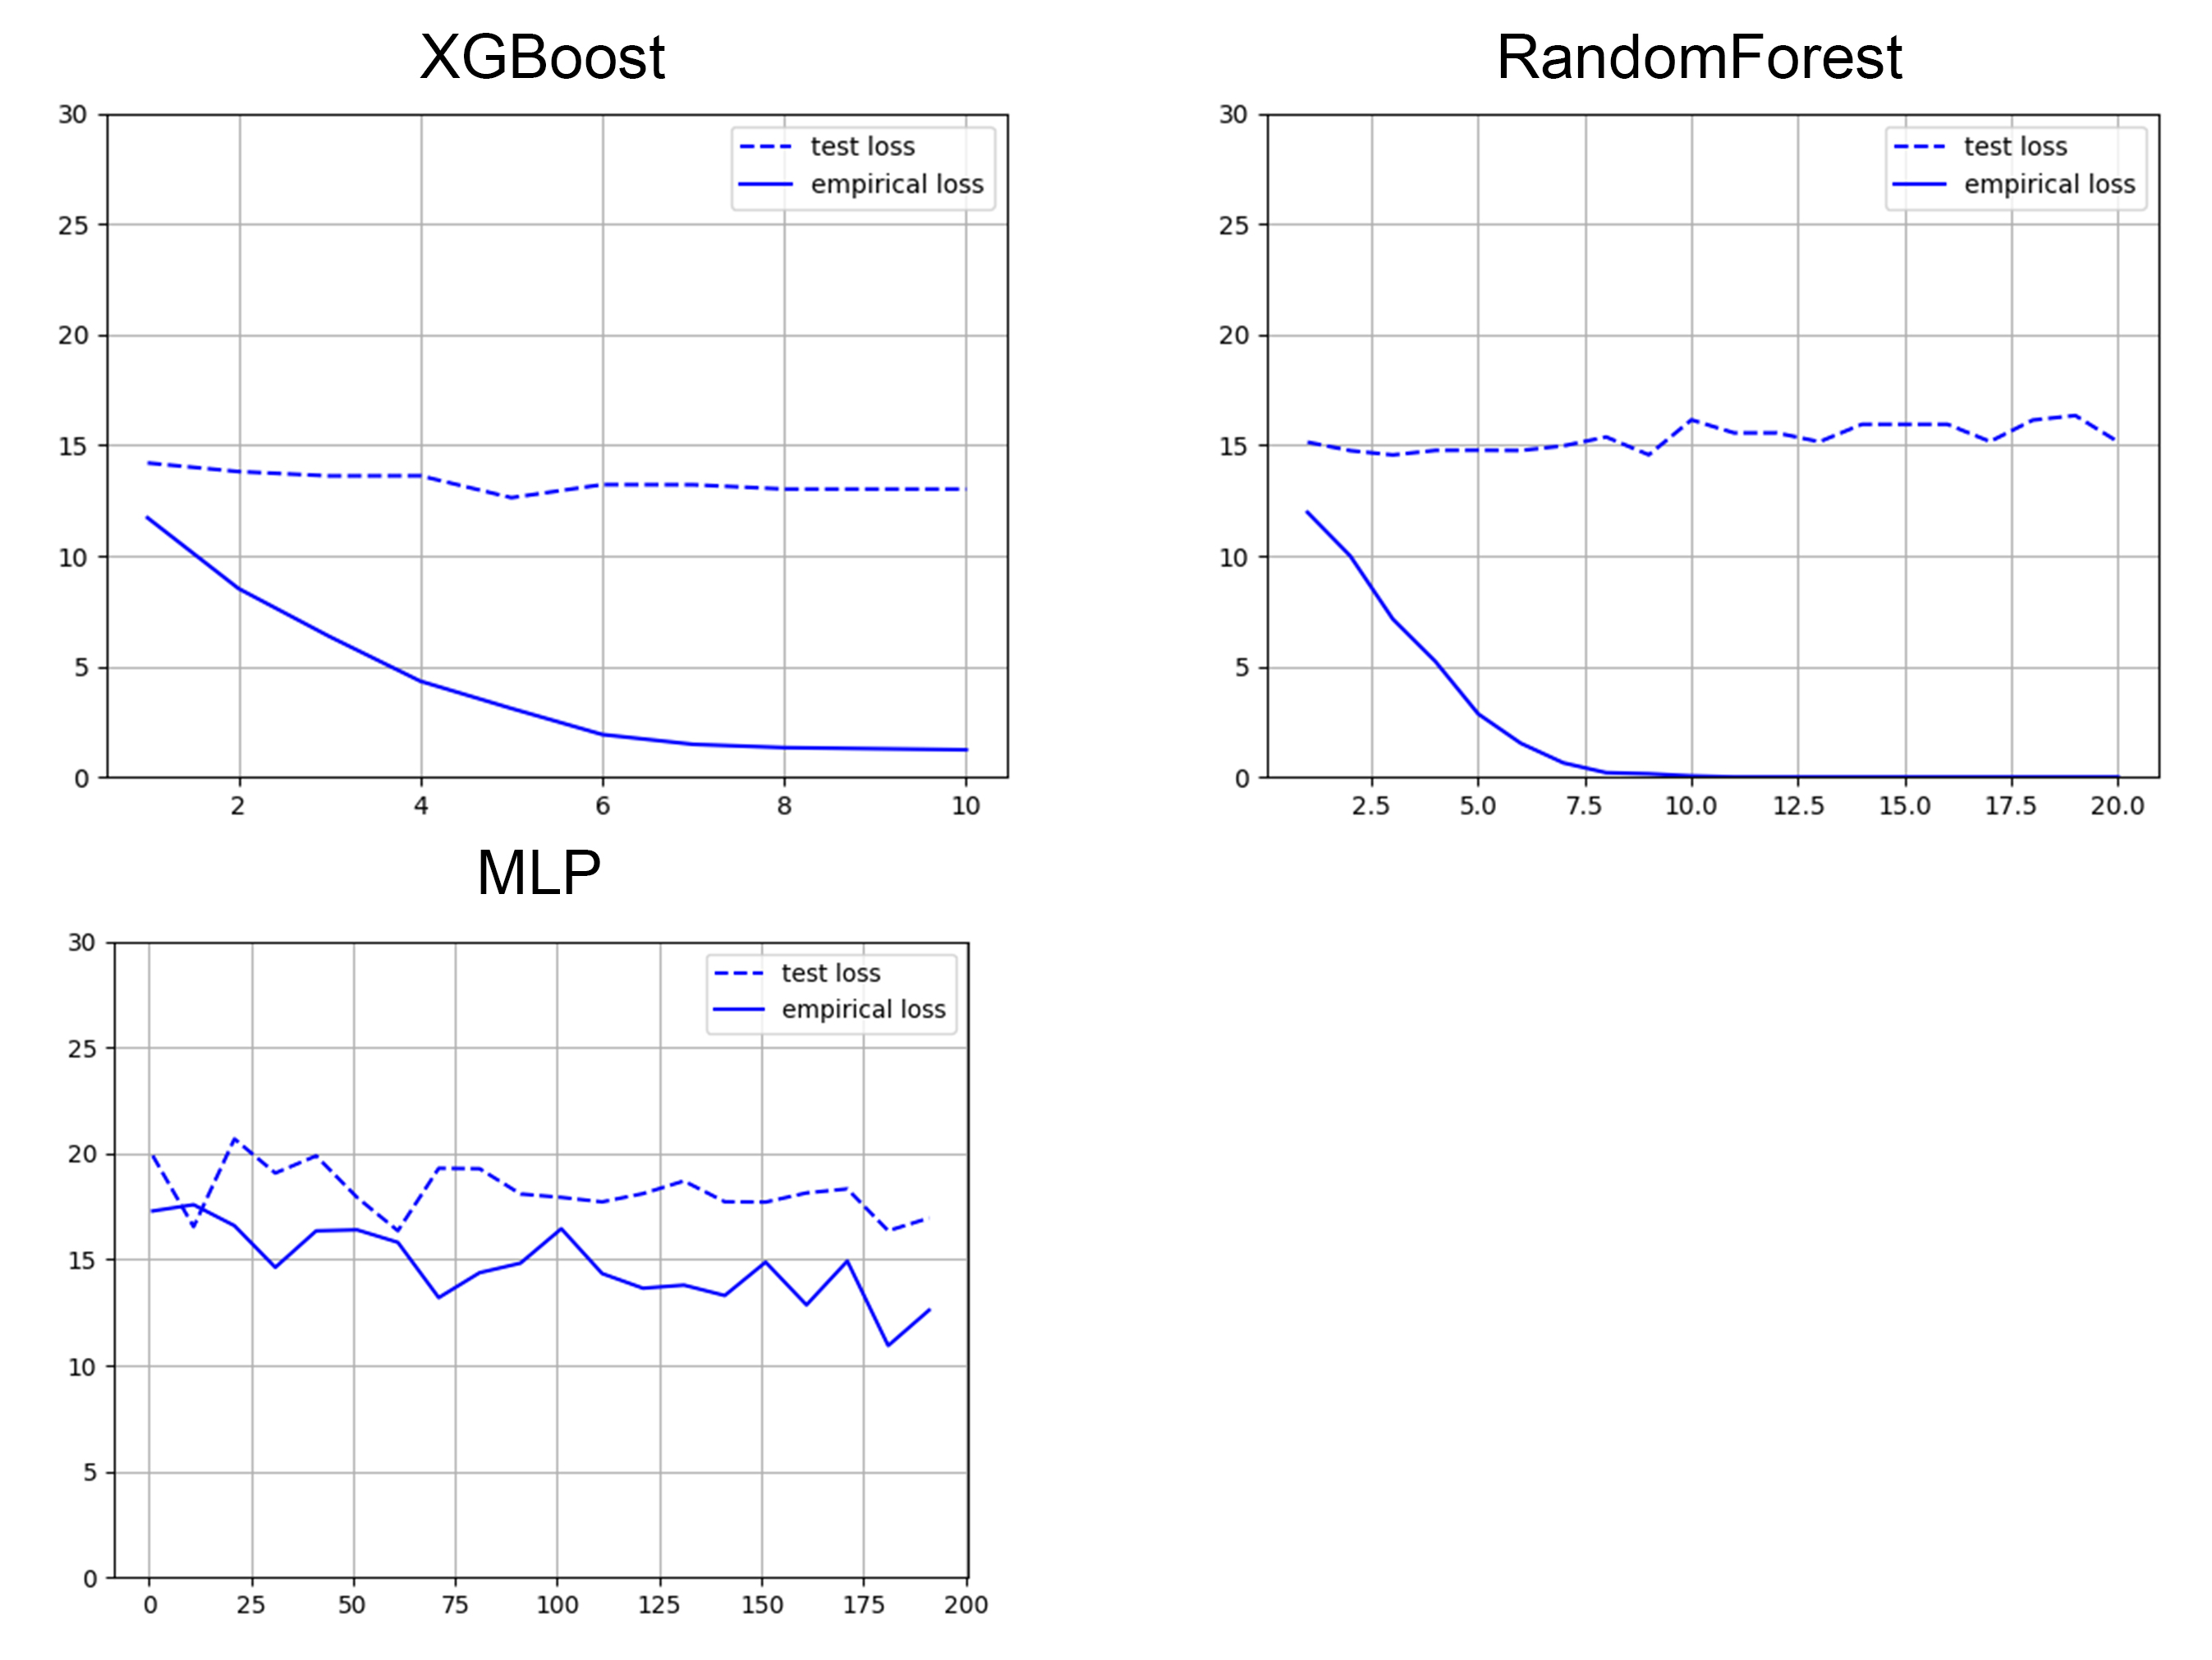

In [221]:
Image(filename='plots/manual/models_capacity_x.jpg')

Agora que selecionamos o melhor modelo podemos analisar como os diferentes conjuntos de features afetam a capacidade preditiva. Para fins comparação gerei X_random, um conjunto de features aleatórias que nos permite ver o quão menor o erro de teste de cada conjunto está em relação ao erro de teste gerado a partir de valores aleatórios.

X_questions e X_drugs geram um desempenho semelhante, porém x_questions gera resultados levemente melhores. Quando usamos todas a as features disponíveis (X) temos o melhor modelo por uma faixa bem pequena.

Com esses resultados não conseguimos afirmar com certeza se os remédios que o paciente toma podem ser usados para predizer se ele vai ter uma melhora em sua dor crônica ou não. Isso porque o melhor desempenho do modelo que usa o conjunto X pode ser explicado tanto pelo presença das features de remédios quanto pelo aumento da dimensionalidade dos dados. Lembrando que quanto maior a dimensionalidade dos dados maior a chance do modelo ser linearmente separável, e por consequência ter um melhor desempenho.

Porém, não podemos esquecer do fato que o modelo que usa X_drugs é tão bom quanto o que usa X_questions. Isso pode ser um indício que os remédios tem sim alguma capacidade preditiva, já que já foi comprovado que X_questions pode ser usado para fazer essa predição (como discutido em nossa reunião).

In [ ]:
Image(filename='plots/manual/xgboost_features.jpg')

Para fazer uma última análise do modelo obtido usaremos o princípio da navalha de Ockham para escolher o conjunto de features X_questions, já que ele é menos complexo que X e gera um modelo com aproximadamente a mesma qualidade.

Podemos observar que pela confusion matrix dos dados originais (com uma distribuição assimétrica) que o modelo é completamente desbalanceado, só sabendo identificar verdadeiros negativos e tendo uma péssima acurácia para verdadeiros positivos. Enquanto o outro, apesar de ter piores resultados, é mais balanceado em suas classificações.

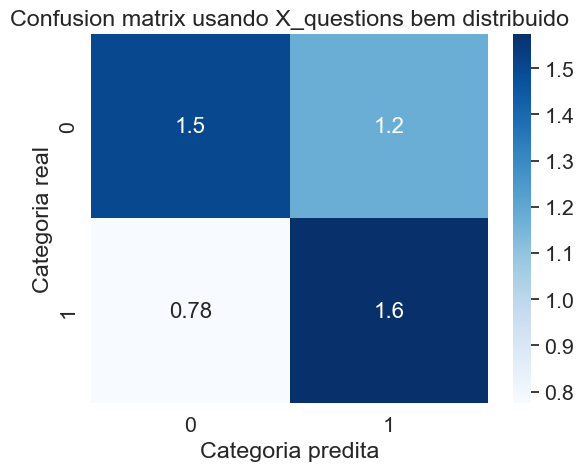

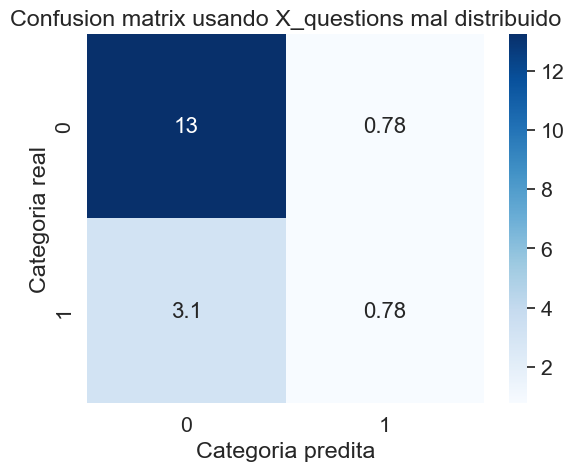

In [218]:
def meanConfusionMatrix(X, y, name):
    k = 40
    mean_confusion_matrix = np.zeros((2,2))
    kfold = KFold(n_splits=k, shuffle=True)

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        mean_confusion_matrix += confusion_matrix(y_test, y_pred)

    mean_confusion_matrix /= k
    sns.set(font_scale=1.4)
    sns.heatmap(mean_confusion_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='.2g')

    plt.title(name)
    plt.xlabel('Categoria predita')
    plt.ylabel('Categoria real')
    plt.show()

meanConfusionMatrix(X_questions, y, 'Confusion matrix usando X_questions bem distribuido')
Image(filename='plots/manual/confusion_matrix_original_data.png')

Vejamos quais são as features mais importantes para o classificador XGBoost.

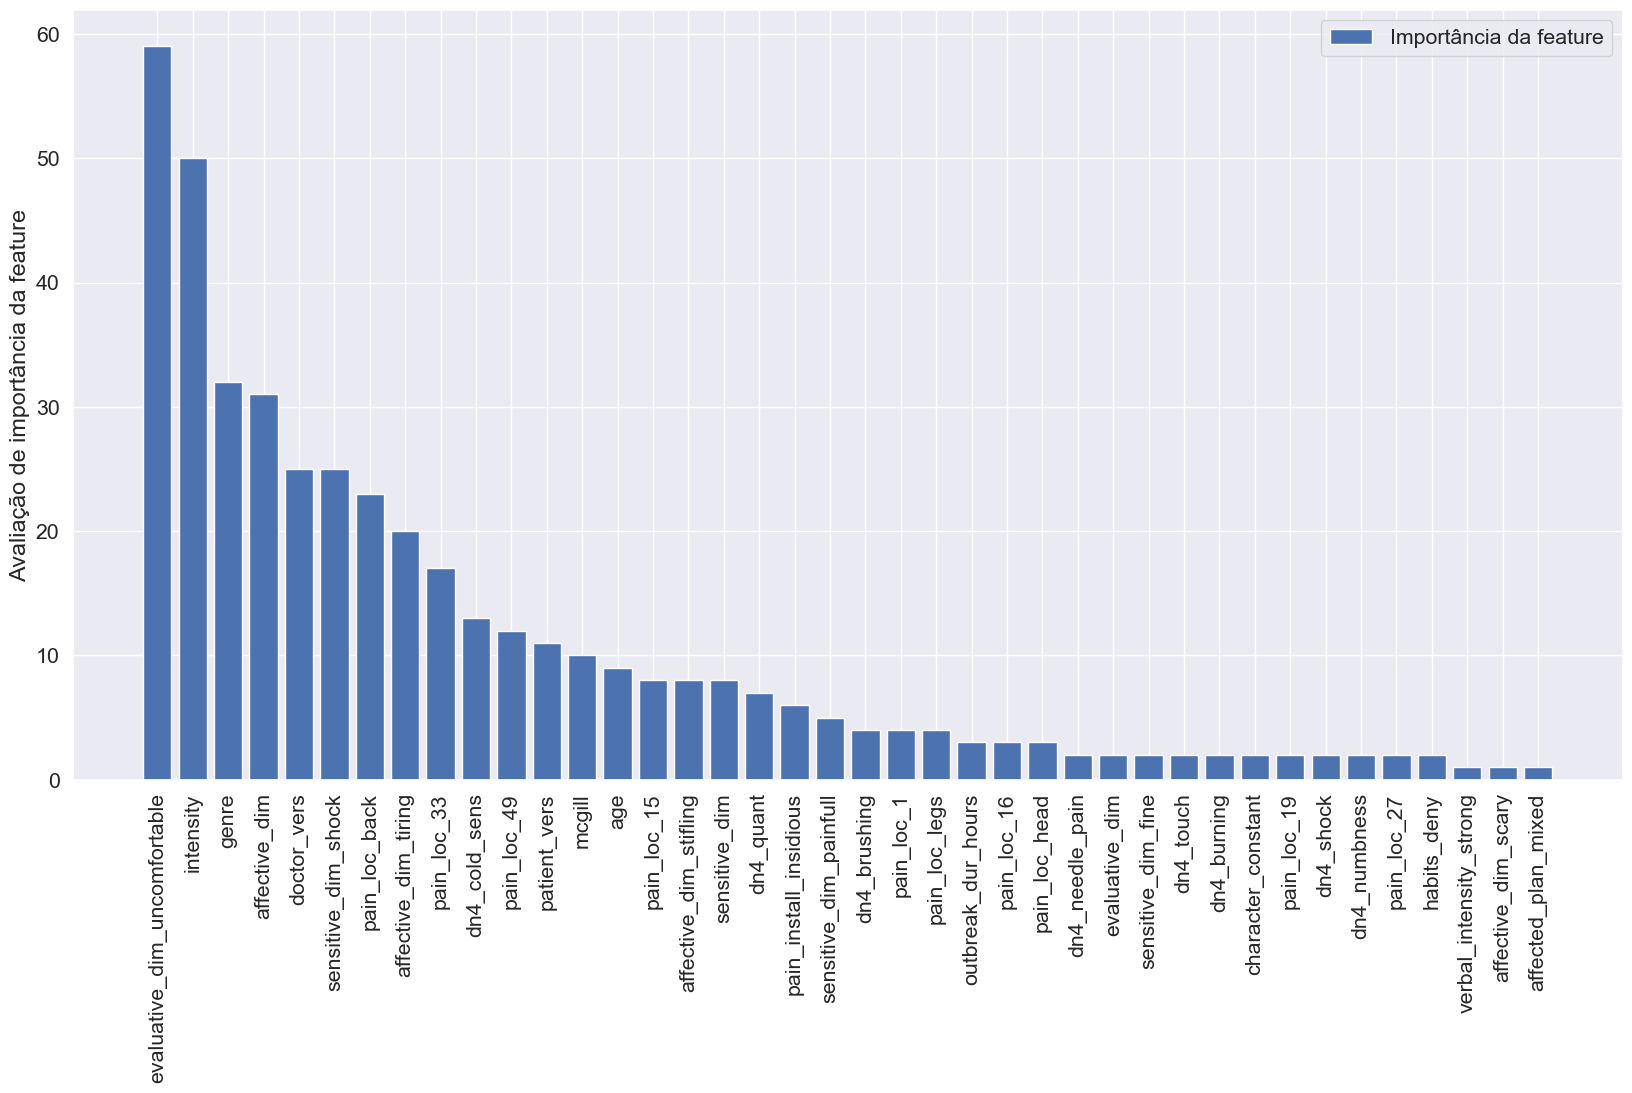

In [222]:
df = pd.read_csv("data.csv")
questions = df.iloc[:, 2:182] # As duas primeiras colunas são irrelevantes (id e data de nascimento)
questions = questions.drop('date_visit', axis=1) # Data de visita não é relevante
questions = questions.drop(questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

drugs = data.iloc[:, 185:]
drugs = drugs.drop(drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,
                                        142,143,148,151,152]], axis=1) # Essas colunas são constantes

features = pd.concat([questions, drugs], axis=1)
features = list(features.columns)
# print(features)

clf = xgb.XGBClassifier(max_depth=3,  gamma=0.7, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
clf.fit(X_questions, y)

feat_imp = pd.Series(clf.get_booster().get_fscore())
feat_imp.index = pd.Index(feat_imp.index)
feat_imp.sort_values(ascending=False, inplace=True)

x_plot = [ int(f.replace("f", "")) for f in feat_imp.index]
y_plot = [ feat_imp[f] for f in feat_imp.index]
x_plot = [features[feature_index] for feature_index in x_plot]

max_features = 40
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x_plot[:max_features], y_plot[:max_features], label="Importância da feature")
ax.set_ylabel("Avaliação de importância da feature")
plt.xticks(rotation=90)
ax.legend()
plt.show()

Conclusão: Mais dados são necessários para afirmar responsavelmente se os remédios predizem (ou não) a melhora dos pacientes, principalmente dados de casos positivos.